# TP5 GaboG

Para una imagen de elección...

In [2]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline
#matplotlib
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [3]:
def read_and_plot_image(image_path):
    
    img = cv.imread(image_path)
    fig = plt.figure(figsize=(7,7))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

    return img

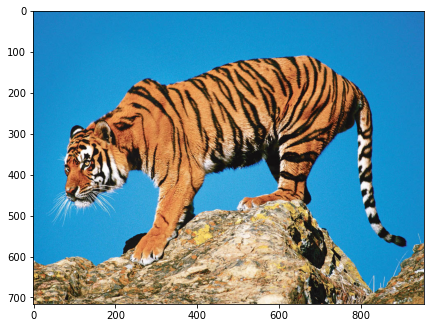

In [4]:
image = read_and_plot_image('tiger.jpg')

1. Construir un espacio de características basado en color y graficar la distribución de características

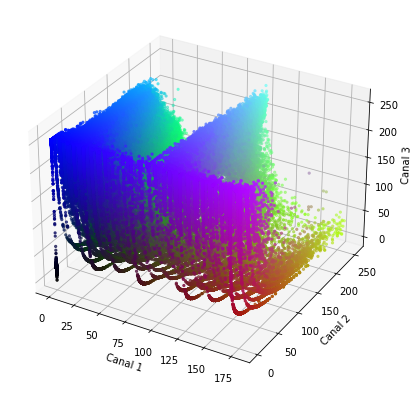

In [5]:
# Transform to HSV color space
img_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

# Plot hsv color space
h, s, v = cv.split(img_hsv)
fig = plt.figure(figsize=(7,7))
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = img_hsv.reshape((np.shape(img_hsv)[0]*np.shape(img_hsv)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Canal 1")
axis.set_ylabel("Canal 2")
axis.set_zlabel("Canal 3")
plt.show()

2. Construir un espacio de características basado en color y posición y graficar la distribución de características

In [6]:
# Transform to RGB color space
img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Create x,y features
matrix_x = np.zeros((img_rgb.shape[0], img_rgb.shape[1]))
matrix_y = np.zeros((img_rgb.shape[0], img_rgb.shape[1]))

for x in range(0, img_rgb.shape[1]):
        for y in range(0, img_rgb.shape[0]):
            matrix_x[y,x] = x
            matrix_y[y,x] = y

# Scaling x,y features between 0-255 (k-means is sensitive to scale)

matrix_x = np.interp(matrix_x, (matrix_x.min(), matrix_x.max()), (0, +255)) 
matrix_y = np.interp(matrix_y, (matrix_y.min(), matrix_y.max()), (0, +255)) 

matrix_xy = np.zeros((img_rgb.shape[0],img_rgb.shape[1],2))

# Adding values to a 2-dim matrix. 
matrix_xy[:,:,0] = matrix_x
matrix_xy[:,:,1] = matrix_y

In [7]:
# Validate shapes
(img_rgb.shape, matrix_xy.shape)

((716, 954, 3), (716, 954, 2))

In [8]:
# Concatenate both matrix into a 5-dim matrix 

rgbxy_matrix = np.c_[np.asarray(img_rgb), matrix_xy]
rgbxy_matrix.shape

(716, 954, 5)

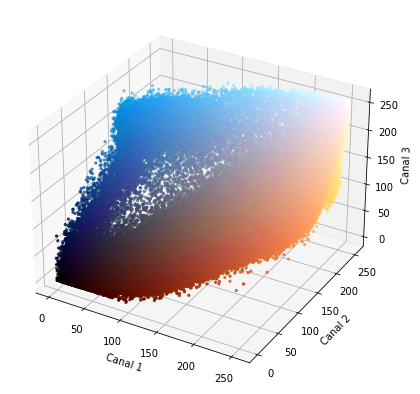

In [10]:
# Plot RGB space color

r, g, b = cv.split(rgbxy_matrix[:,:,:3])

fig = plt.figure(figsize=(7,7))
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = img_rgb.reshape((np.shape(img_rgb)[0]*np.shape(img_rgb)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Canal 1")
axis.set_ylabel("Canal 2")
axis.set_zlabel("Canal 3")
plt.show()

3. Obtener la imagen posterizada y las máscaras correspondientes a cada clase, utilizando k-means con asignación aleatoria de centroides para ambos espacios de características.

In [11]:
# Cambiamos el tamaño a un array de Mx3 (con M el número de píxels).
features_hsv = img_hsv.reshape((-1,3))
print('Dimensión de la matriz de características (espacio HSV): {}'.format(features_hsv.shape))
features_hsv = np.float32(features_hsv)

Dimensión de la matriz de características (espacio HSV): (683064, 3)


In [12]:
# Cambiamos el tamaño a un array de Mx5 (con M el número de píxels).
features_rgbxy = rgbxy_matrix.reshape((-1,5))
print('Dimensión de la matriz de características (espacio RGBXY): {}'.format(features_rgbxy.shape))
features_rgbxy = np.float32(features_rgbxy)

Dimensión de la matriz de características (espacio RGBXY): (683064, 5)


In [13]:
# Definimos el criterio de detención (Epsilon e iteraciones máximas) y número de clústers (K)
criteria = (cv.TERM_CRITERIA_MAX_ITER + cv.TERM_CRITERIA_EPS, 10, 1.0)
K = 3

# Corremos kmeans
compact_hsv, label_hsv, color_clusters_hsv = cv.kmeans(features_hsv, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
compact_rgbxy, label_rgbxy, color_clusters_rgbxy = cv.kmeans(features_rgbxy, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

In [14]:
# Cast color_clusters data type to uint8
color_clusters_hsv = np.uint8(color_clusters_hsv)
color_clusters_rgbxy = np.uint8(color_clusters_rgbxy)

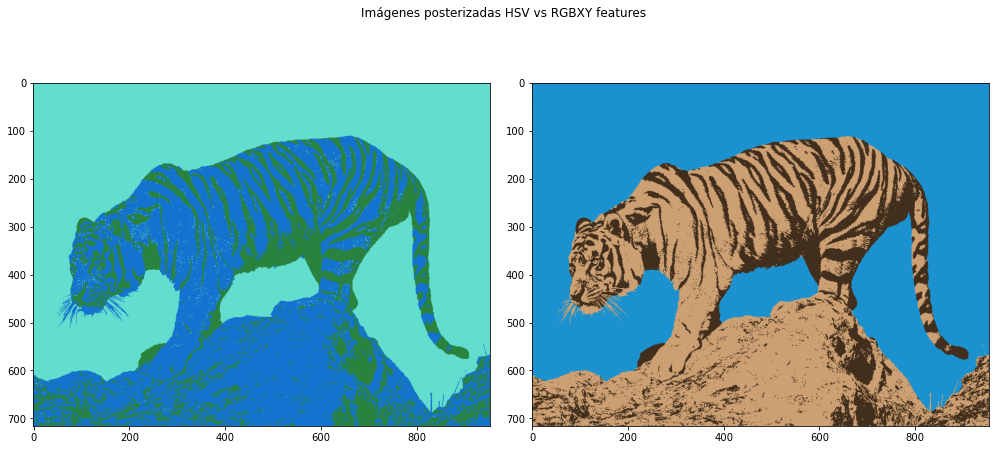

In [26]:
# Cada píxel que corresponde a un grupo tiene copiado como etiqueta el color al que corresponde. Hacemos un reshape al tamaño original de la matriz de imagen 
img_out_hsv = color_clusters_hsv[label_hsv.flatten()]
img_out_hsv = img_out_hsv.reshape((img_hsv.shape))

img_out_rgbxy = color_clusters_rgbxy[label_rgbxy.flatten()][:, :3]
img_out_rgbxy = img_out_rgbxy.reshape((img_rgb.shape))

# Mostramos la imagen compuesta
fig, axs = plt.subplots(1, 2, figsize=(14,7))
fig.suptitle('Imágenes posterizadas HSV vs RGBXY features')
fig.tight_layout() 

axs[0].imshow(img_out_hsv)
axs[1].imshow(img_out_rgbxy)

plt.show()

In [52]:
# Obtenemos máscaras de la segmentación y la imagen segmentada en RGB usando el espacio de color HSV

mask_list_hsv = list()
img_segmented_hsv = list()
for cluster in color_clusters_hsv:
  mask = np.zeros(img_out_hsv.shape[:2],'uint8')
  mask[np.where((img_out_hsv == cluster).all(axis=2))] = 255
  mask_list_hsv.append(mask)
  img_segmented_hsv.append(cv.cvtColor(cv.bitwise_and(img_hsv, img_hsv, mask = mask), cv.COLOR_HSV2RGB))

In [48]:
# Obtenemos máscaras de la segmentación y la imagen segmentada usando el espacio de color RGB y posicion X,Y

mask_list_rgbxy = list()
img_segmented_rgbxy = list()
for cluster in color_clusters_rgbxy[:, 0:3]:
  mask = np.zeros(img_out_rgbxy.shape[:2],'uint8')
  mask[np.where((img_out_rgbxy == cluster).all(axis=2))] = 255
  mask_list_rgbxy.append(mask)
  img_segmented_rgbxy.append(cv.bitwise_and(img_rgb, img_rgb, mask = mask))

In [53]:
# Unimos resultados
mask_list = mask_list_hsv + mask_list_rgbxy[::-1]

img_segmented = img_segmented_hsv + img_segmented_rgbxy[::-1]

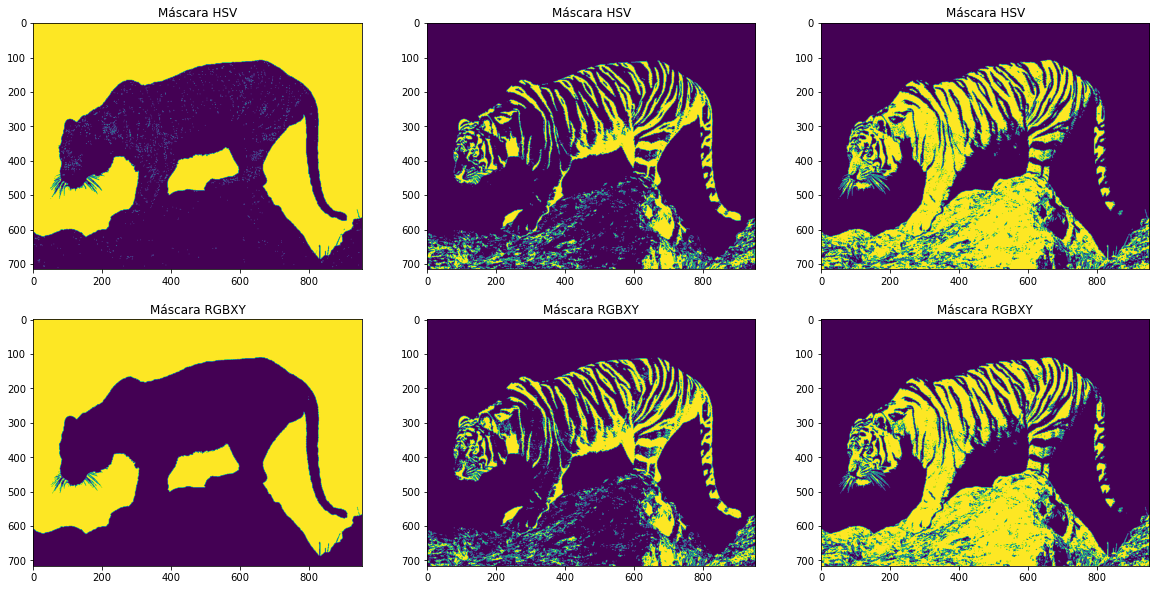

In [47]:
fig = plt.figure(figsize=(20,10))
c=1 
for i in mask_list:
    plt.subplot(2, 3, c)
    if c <= 3:
        plt.title(f'Máscara HSV')
    else: 
        plt.title(f'Máscara RGBXY')
    ax = plt.imshow(i)
    c += 1

5. Comparar los resultados obtenidos

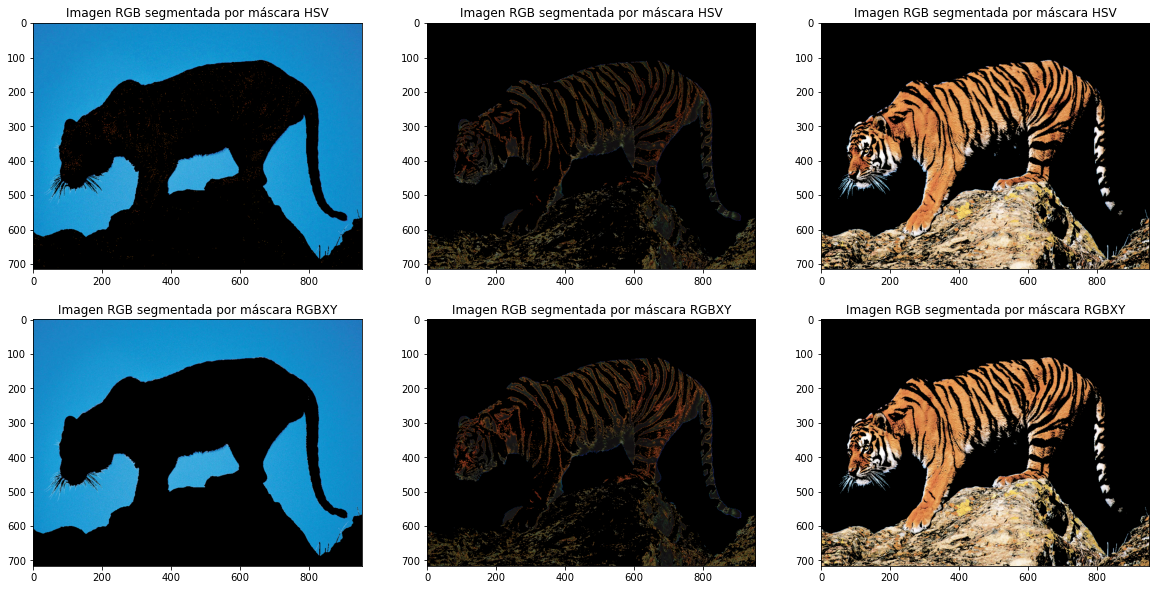

In [58]:
fig = plt.figure(figsize=(20,10))
c=1 
for i in img_segmented:
    plt.subplot(2, 3, c)
    if c <= 3:
        plt.title(f'Imagen RGB segmentada por máscara HSV')
    else: 
        plt.title(f'Imagen RGB segmentada por máscara RGBXY')
    ax = plt.imshow(i)
    c += 1

En general, y sobre todo en el cluster que separa el cielo del resto de la imagen, los resultados son mucho mejores con el espacio de características basado en color RGB y posición x,y. Sin embargo, en ambos métodos no se logra distinguir entre la montaña y el tigre debido a que tienen colores similares, y además, se asignaron pocos clústeres en la segmentación por k-means.